<a href="https://colab.research.google.com/github/maricari/NLP/blob/main/6_bot_qa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA con Fasttext

## Alumna: María Carina Roldán

### Objetivo
Implementar un bot basado en el ejemplo del traductor pero con un dataset de QA.

Utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés.
[LINK](http://convai.io/data/)

In [57]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [58]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input


In [59]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [60]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [61]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [62]:
for i in (0,1,2): print(data[i]['dialog'])

[{'id': 0, 'sender': 'participant1', 'text': 'hi there', 'evaluation_score': None, 'sender_class': 'Human'}]
[{'id': 0, 'sender': 'participant1', 'text': 'Hello!', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 1, 'sender': 'participant2', 'text': 'Hi! How are you?', 'evaluation_score': None, 'sender_class': 'Bot'}, {'id': 2, 'sender': 'participant1', 'text': 'Not bad! And You?', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 3, 'sender': 'participant2', 'text': "I'm doing well. Just got engaged to my high school sweetheart.", 'evaluation_score': None, 'sender_class': 'Bot'}, {'id': 4, 'sender': 'participant1', 'text': 'Wowowowow! Congratulations! Is she pretty?', 'evaluation_score': None, 'sender_class': 'Human'}, {'id': 5, 'sender': 'participant2', 'text': "She 's pretty cute. She invited me to dinner tonight. 🙂", 'evaluation_score': None, 'sender_class': 'Bot'}, {'id': 6, 'sender': 'participant1', 'text': 'Cool! Have a good time you both! And what is your hob

In [63]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [64]:
for i in range(5):
  print(f"{input_sentences[i]}\n\t{output_sentences[i]}\n\t{output_sentences_inputs[i]}")

hello 
	hi how are you  <eos>
	<sos> hi how are you 
hi how are you 
	not bad and you  <eos>
	<sos> not bad and you 
hi 
	hello  <eos>
	<sos> hello 
hi 
	hello  <eos>
	<sos> hello 
hi 
	hello how are you today  <eos>
	<sos> hello how are you today 


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [65]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [66]:
# Tokenizar las palabras con el Tokenizer de Keras

# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [67]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


In [68]:
max_input_len = 10
max_out_len = 10

In [69]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 10)
decoder_input_sequences shape: (6033, 10)


In [70]:
from keras.utils.np_utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 1807)

### 3 - Preparar los embeddings
Se utilizaron embeddings de FastText.

In [71]:
# 
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 2746M  100 2746M    0     0  89.0M      0  0:00:30  0:00:30 --:--:--  110M


In [72]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Diccionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60


In [73]:
model_embeddings = FasttextEmbeddings()

In [74]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [75]:
# Dimensión de los embeddings de la secuencia
embedding_matrix.shape

(1799, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores.

In [76]:
# plot de resultados

import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracy(h):
  epoch_count = range(1, len(h.history['accuracy']) + 1)
  sns.lineplot(x=epoch_count,  y=h.history['accuracy'], label='train')
  sns.lineplot(x=epoch_count,  y=h.history['val_accuracy'], label='valid')
  plt.show()

In [89]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model

In [101]:
# Modelo

n_units = 256

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dropout = Dropout(0.5)
decoder_outputs = decoder_dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 10, 300)      539700      ['input_25[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 10, 256)      462592      ['input_26[0][0]']               
                                                                                           

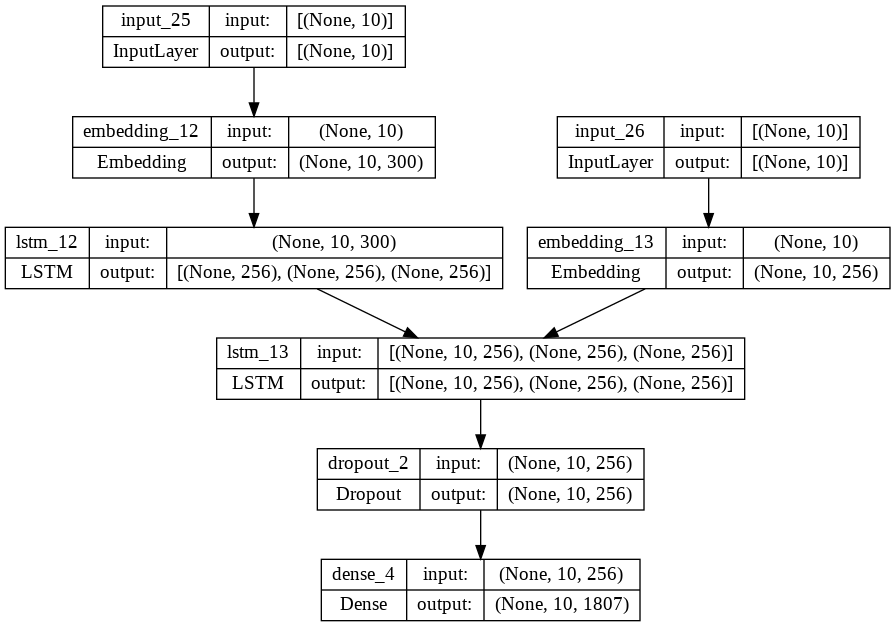

In [102]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

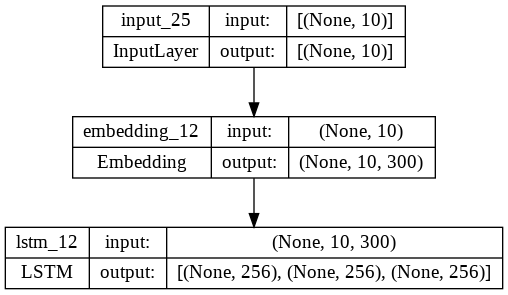

In [103]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

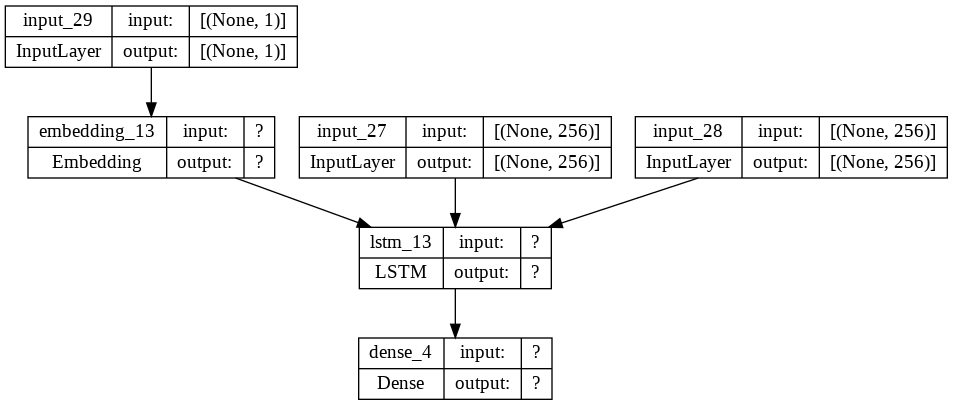

In [104]:
# Modelo solo decoder (para realizar inferencia)
from keras.utils.vis_utils import plot_model

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [105]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50, 
    validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 17s 90ms/step - loss: 2.7040 - accuracy: 0.5555 - val_loss: 2.1325 - val_accuracy: 0.6499
Epoch 2/50
151/151 [==============================] - 14s 92ms/step - loss: 1.8838 - accuracy: 0.6695 - val_loss: 1.8941 - val_accuracy: 0.6905
Epoch 3/50
151/151 [==============================] - 13s 87ms/step - loss: 1.6376 - accuracy: 0.7118 - val_loss: 1.7780 - val_accuracy: 0.7065
Epoch 4/50
151/151 [==============================] - 13s 86ms/step - loss: 1.5118 - accuracy: 0.7288 - val_loss: 1.7174 - val_accuracy: 0.7137
Epoch 5/50
151/151 [==============================] - 13s 87ms/step - loss: 1.4315 - accuracy: 0.7374 - val_loss: 1.6801 - val_accuracy: 0.7170
Epoch 6/50
151/151 [==============================] - 14s 91ms/step - loss: 1.3747 - accuracy: 0.7419 - val_loss: 1.6572 - val_accuracy: 0.7204
Epoch 7/50
151/151 [==============================] - 13s 87ms/step - loss: 1.3269 - accuracy: 0.7468 - val_loss: 1.6383 - val_accuracy:

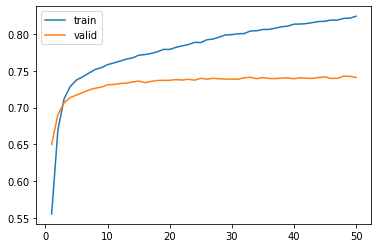

In [106]:
plot_accuracy(hist)

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [84]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [107]:
def responder_pregunta(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [135]:
# probando ...
i = np.random.choice(len(input_sentences))
question = encoder_input_sequences[i:i+1]
answer = responder_pregunta(question)
print('-')
print('Pregunta:', input_sentences[i])
print('Respuesta:', answer)

1/1 [==============================] - 0s 17ms/step
-
Pregunta: what do you do for a living 
Respuesta: i m a student


In [123]:
def respuesta(pregunta):
  integer_seq_test = input_tokenizer.texts_to_sequences([pregunta])[0]
  encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
  respuesta = responder_pregunta(encoder_sequence_test)
  return respuesta

pregunta = "Do you want to go out?"
print (respuesta(pregunta))

1/1 [==============================] - 0s 17ms/step
i like to play video games


### Probando con un banco de preguntas

In [132]:
sample_questions = [
    'What time is it?',
    'Do you like my eyes?',
    'What`s your favorite drink?',
    'What`s your favorite food?',
    'How old is your sister?',
    'Do you like cats or dogs?',
    'Are we friends?',
    'Where do you live?',
    'Where are you from?',
    'Do you know how to code?'
]

In [ ]:
import pandas as pd
df = pd.DataFrame()
df_row = {'pregunta': "", 'respuesta': ""}
print(type(new_row))
for q in sample_questions:
  print(q)
  df_row['pregunta'] = q
  df_row['respuesta'] = respuesta(q)
  df = df.append(df_row, ignore_index=True)


In [134]:
df

,pregunta,respuesta
0,What time is it?,i love to go to the beach
1,Do you like my eyes?,i do not like it
2,What`s your favorite drink?,i like to play video games
3,What`s your favorite food?,i like to read
4,How old is your sister?,i m a bathroom singer
5,Do you like cats or dogs?,i like to play video games
6,Are we friends?,i love to cook
7,Where do you live?,i like to play video games
8,Where are you from?,i m from the united states
9,Do you know how to code?,i do not know what to say


### Resumen y Conclusiones

A partir del modelo original se probaron algunas variantes:
- **modelo 1**. Versión original (inspirada en el traductor)
- **modelo 2**. modelo 1 + una layer de dropout de 0.5 en el decoder
- **modelo 3**. modelo 2 + se pasa de dimensionalidad 128 a 256
- **modelo 4**. modelo 3 + dropout de 0.2 en las layers LSTM

Todos los modelos se corrieron 50 epochs.
Los resultados después de la última epoch fueron los siguientes:

```
Modelo 1 - 2s 11ms/step - loss: 0.7233 - accuracy: 0.8246 - val_loss: 1.8063 - val_accuracy: 0.7365
Modelo 2 - 2s 10ms/step - loss: 0.9273 - accuracy: 0.7897 - val_loss: 1.7788 - val_accuracy: 0.7399
Modelo 3 - 2s 11ms/step - loss: 0.6462 - accuracy: 0.8347 - val_loss: 1.9015 - val_accuracy: 0.7360
Modelo 4 - 13s 87ms/step - loss: 0.6989 - accuracy: 0.8241 - val_loss: 1.8333 - val_accuracy: 0.7408
```

No hay mucha diferencia entre ellos. En todos los casos la accuracy de validación empieza subiendo y después se "congela" alrededor de 0.72

Con el último modelo se realizaron algunas pruebas con un banco de preguntas y la mayoría de las respuestas no tuvieron mucho sentido.

Como siempre, para obtener mejores resultados además de hacer este tipo de pruebas se podría experimentar con un set de datos más grande o de mejor calidad. En este caso el dataset disponible no se puede probar por las limitaciones del Colab.

